In [1]:
import numpy as np
import matplotlib.pyplot as plt
import resfuncRead as rfr
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab

In [2]:
#read the files (from anthony)
#ptres = rfr.getRFunc('data/jardin_ptres.txt')
#qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

In [3]:
k = 0.157 # from lindhard
q = 1.602*10**-19 #electron charge 
V = 4.0 # voltage Bias
eps = .0033 #keV

#for detector 1.

p_alpha = 0.155393
p_beta = 9.60343*10**(-11)
p_gamma = 0.000506287

q_alpha = 0.166004
q_beta = 0.00233716
q_gamma = 9.52576*10**(-5)

In [4]:
x = np.arange(0,400,0.1)
#Er = 93*np.exp(-x/29) #For NR from Kennedy Thesis 

N = 2500
Er = np.random.exponential(40,np.uint32(N*0.5)) #tip from anthony 

#need to store all of this inorder to calculate fano factor.
ER = []
Yield = []
PtNr = []
QR = []
sigQ = []
sigP = []
sigQ1 = []
sigP1 = []

U1 = []
U2 = []
N_eh = []

QNR=[]
PT1 = []
Neh1 = []

In [5]:
#For Nuclear Recoils 
F =50

'''
Neh = Y*Enr/eps
#(ylindv(Enr*1000.0)*Enr)/(eps/1000)
sigf_p = q*V*np.sqrt(Neh*F)
sigf_q = eps*np.sqrt(Neh*F)
'''

for i in np.arange(0,N):
    
    Enr = np.random.choice(Er)
    #Enr = 40
    esp = 11.5*Enr*(23)**-(7/3)
    g = 3*esp**(0.15)+0.7*esp**(0.6)+esp
    Y = k*g/(1+k*g)
    

    
    Neh = Y*Enr/eps #number of electron-hole pairs. 
    Ptnr = (Y*Enr*V)/(eps*1000) + Enr #central value of Pt
    Qnr = Y*Enr
    
    
    N_eh.append(Neh)
    #(ylindv(Enr*1000.0)*Enr)/(eps/1000)
    #sigf_p = q*V*np.sqrt(Neh*F)
    #sigf_q = eps*np.sqrt(Neh*F)
    
    
    #Without Fano Factor 
    sig_p1 = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) )  
    sig_q1 = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) )
    
   #With Fano Factor. 
    sig_p = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) + (V/1000)**2*Neh*F)  #Phonon uncertainty (energy dependent)
    sig_q = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) + eps**2*Neh*F) #Charge uncertainty 
    

    
    sigQ.append(sig_q)
    sigP.append(sig_p)
    sigQ1.append(sig_q1)
    sigP1.append(sig_p1)
    
    Fnr = np.random.normal(0.0,sig_p) #random sample assuming phonon variance 
    Fq = np.random.normal(0.0,sig_q) #random sampel assuming charge variance 
    

    #Ptnr = (Y*Enr*V)/eps + Enr #total phonon energy 
    Ptnr1 = Ptnr + Fnr #not central value! just.. smeared 
    PT1.append(Ptnr1)

    Qnr1 = Qnr + Fq 

    QNR.append(Qnr1)
    
    U_1 = (Ptnr*eps**2)/((V*Qnr1/1000)-Ptnr1*eps)**2 #derivative with respect to Qnr1
    U1.append(U_1)
    U_2 = -Qnr1/(Ptnr1 -(Qnr1*V/(eps*1000)))**2      #derivative with respect to Ptnf
    U2.append(U_2)
    
    Ernr = Ptnr1 - (V/(eps*1000))*Qnr1
    ER.append(Ernr)

    yield1 = Qnr1 / Ernr
    Yield.append(yield1)
    
    NEH = yield1*(Enr/eps)
    Neh1.append(NEH)
    

(0, 10000)

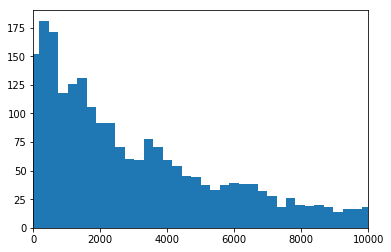

In [6]:
plt.hist(Neh1,bins = 600)
plt.xlim(0,10000)

In [7]:
Yield_er = []
ERer = []



In [8]:
#For Electron Recoils. 

#x = np.arange(0,2000,0.1)
#E1er = 82*np.exp(-x/304) #For ER from Kennedy Thesis
E1er = np.random.uniform(0,200,N) #from anthony, Er's are close enough to randomly distributed. 



for i in np.arange(N):
    
    Eer = np.random.choice(E1er) #randomly sample from Energy dist 
    
    
    sig_pee = np.sqrt(p_alpha + p_beta*Eer + p_gamma*(Eer**2)) #Phonon uncertainty 
    sig_qee = np.sqrt(q_alpha + q_beta*Eer + q_gamma*(Eer**2)) #Charge uncertainty 

    Fer = np.random.normal(0.0,sig_pee) #Random energy assuming phonon variance 
    Fqe = np.random.normal(0.0,sig_qee) #Random assuming charge variane


    Pter = (1+(V/eps/1000))*Eer 
    Pter = Pter + Fer
    Qer = Eer
    Qer = Qer + Fqe

    Erer = Pter - (V/eps/1000)*Qer
    ERer.append(Erer)
    
    Yield2 = Qer/Erer
    Yield_er.append(Yield2)

In [9]:
# Make band Fits (Thank you Anthony)

# files contain fits from previous data. I believe that they are fits from real data. As seen, the model has a significantly narrower spread the fits 
# from the data 

bpar_er = rfr.getBandFunc('data/erband_R133') #reads in band data/fit for er data
bpar_nr = rfr.getBandFunc('data/nrband_R133') #reads in band data/fit for nr data 

yer_mu = rfr.makeBFunc(bpar_er[1]['mu']) # sets average fit from 1st (2nd) col in data table. 
yer_muv = np.vectorize(yer_mu) #puts mean data for er in 1D array 
yer_sig = rfr.makeBFunc(bpar_er[1]['sig'],True) #sets uncertainty 
yer_sigv = np.vectorize(yer_sig) #puts uncertainty into 1D array

#following does the same but for nuclear recoils. 
ynr_mu = rfr.makeBFunc(bpar_nr[1]['mu'])
ynr_muv = np.vectorize(ynr_mu)
ynr_sig = rfr.makeBFunc(bpar_nr[1]['sig'],True)
ynr_sigv = np.vectorize(ynr_sig)

# try new fit

xn = np.arange(0.1,100,0.1)
m, c = np.polyfit(ER, Yield, 1)
yn = np.polyval([m, c], xn)

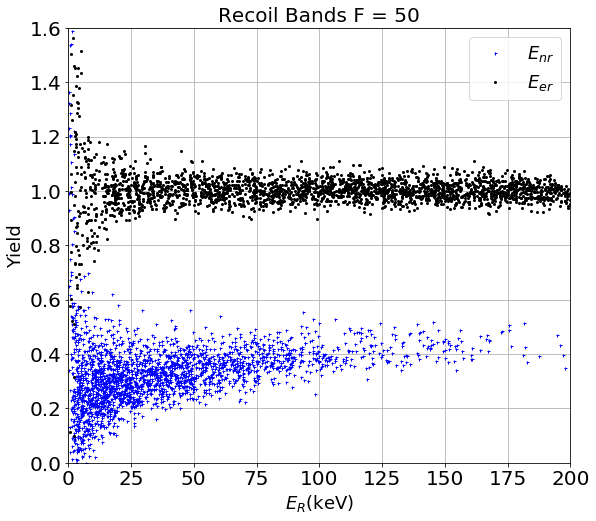

In [10]:
#plot 


fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)

ax1.plot(ER,Yield,'+',color='b',linewidth=2,markersize=3,label = "$E_{nr}$")
ax1.plot(ERer,Yield_er,'o',color='k',linewidth=2,markersize=2,label = "$E_{er}$")
'''
ax1.plot(X,ynr_muv(X),color = 'orange',label='NR mu') #using old data 
#ax1.plot(xn,yn,'r--') #new fit to data (mean)

ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='purple',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='purple',linestyle='-',label='ER 3$\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='purple',linestyle='-',label=None)
'''
ax1.set_xlabel('$E_R$(keV)',size = '18')
ax1.set_ylabel('Yield',size = '18')
ax1.set_title('Recoil Bands F = 50',size = '20')
ax1.set_ylim(0,1.6)
ax1.set_xlim(0,200)
ax1.tick_params(axis='both', labelsize = '20')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='-')
ax1.legend(loc=1,prop={'size':18})




plt.savefig('figures/Recoil_F=50.png')
#plt.savefig('figures/Recoil_F=0.png')
plt.show()


In [11]:

data = np.vstack((ER,Yield,sigQ1,sigP1,U1,U2,N_eh)).T
print(data.shape)

x = data[data[:,1]>=0, :]
data1 = x[x[:,1]<=1.6,:]

#data = np.vstack((Er,Y)).T
#print(data)
#np.savetxt("test_data.txt",data)

data1 = data1[np.argsort(data1[:, 0])]



(2500, 7)


In [12]:
# Lets Try Data Frames.

# THIS IS NOT BEING USED. JUST PLAYING WITH DATA FRAMES. WOULD LIKE TO EVENTULLY USE THIS INSTEAD. 

df = pd.DataFrame(data=data1,)

#print(df)

bins  = [0,50,100,150,200,250,300,400]

df1 = pd.cut(df[0],bins, labels = False)
x = df[1].loc[df1 == 4]

Y = np.average(x)



In [13]:
a,b,c,d,e,f,g = np.array_split(data1,7)
print(a.shape)
data = (a,b,c,d,e,f,g)

i = 0
while i <=1:
    print(data[i])
    i += 1




(347, 7)
[[-1.81034367e-01  1.32608899e-01  4.07444664e-01 ...  9.13962212e-01
   7.32506767e-01  9.27516605e-01]
 [ 1.94008643e-01  9.28749177e-01  4.07802232e-01 ...  2.27759366e+01
  -4.78715362e+00  3.85239324e+01]
 [ 3.34034869e-01  3.42004473e-01  4.07643235e-01 ...  4.60377736e+00
  -1.02385860e+00  2.18487769e+01]
 ...
 [ 7.44784760e+00  1.24224199e-01  4.12430281e-01 ...  1.55830631e-01
  -1.66792079e-02  4.97608936e+02]
 [ 7.53743796e+00  1.20707874e-01  4.12905940e-01 ...  1.64394817e-01
  -1.60144435e-02  5.42264017e+02]
 [ 7.55296204e+00  1.04268354e-01  4.11554659e-01 ...  1.28452129e-01
  -1.38049620e-02  4.14281278e+02]]
[[ 7.56006604e+00  1.53877777e-01  4.12751890e-01 ...  1.59493882e-01
  -2.03540256e-02  5.27847521e+02]
 [ 7.57242156e+00  3.68073290e-01  4.14469898e-01 ...  2.01337945e-01
  -4.86070786e-02  6.86247139e+02]
 [ 7.62298145e+00  1.82180512e-01  4.12756756e-01 ...  1.56994107e-01
  -2.38988528e-02  5.28303609e+02]
 ...
 [ 1.47251726e+01  2.94573466e-01  

In [14]:
def find_sigma(data):
    mu,sigma = norm.fit(data[:,1])

    n,bins = np.histogram(data[:,1],600)

    y = mlab.normpdf(bins, mu, sigma)
 
    plt.figure()
    plt.hist(data[:,1],bins =50,normed = True)
    plt.plot(bins,y, 'r--', linewidth = 2)
    plt.xlabel("Yield")
    plt.show()
    
    return sigma 



In [15]:
#Fano = (b[:,4]**2*b[:,2] +b[:,5]**2*b[:,3] -sigma)**2/(b[:,6]*(b[:,4]**2*eps + V/1000*b[:,5]**2))


def find_fano(data,sigma):
    
    U1 = data[:,4]
    U2 = data[:,5]
    sigQ = data[:,2]
    sigP = data[:,3]
    sigy =sigma 
    N = data[:,6]


    #Fano = 1/(U2**2*(V**2/1000**2) + U1**2*eps**2)*(np.sqrt(U2**2*((V**2)/1000**2)*(sigy**2-U1**2*sigQ) + 2*U1**2*U2**2*(V/1000)*sigQ*sigP*eps +U1**2*eps**2*(sigy**2-U2**2*sigP**2))-q*U2**2*(V/1000)*sigP - U1**2*sigQ*eps)   

    Fano = (-U1**2*sigQ**2-U2**2*sigP**2 + sigy**2)/(U1**2*eps**2 +U2**2*(V/1000)**2)

    Fano = Fano/N

    return Fano 



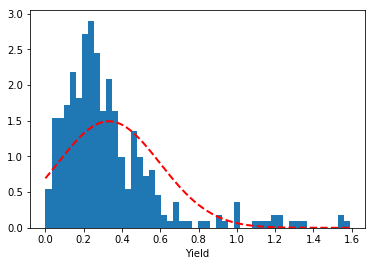

0.26739797002810184


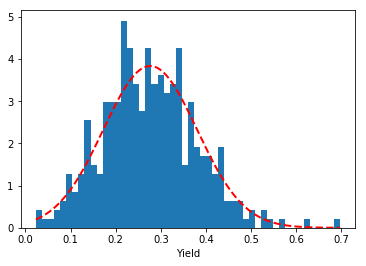

0.10398994331300611


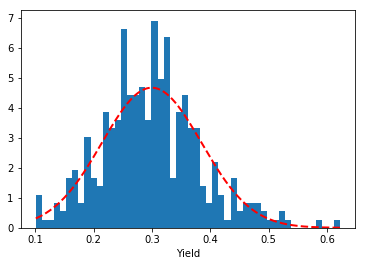

0.0853668667238283


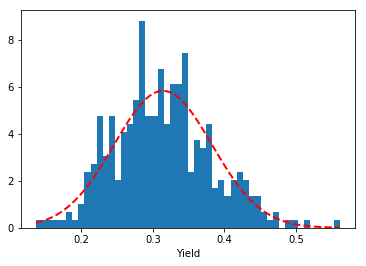

0.0684065330350634


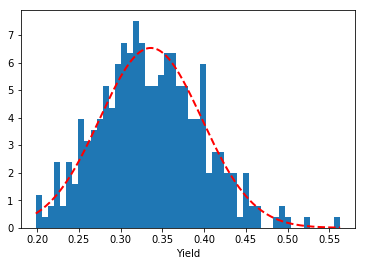

0.0611090307142203


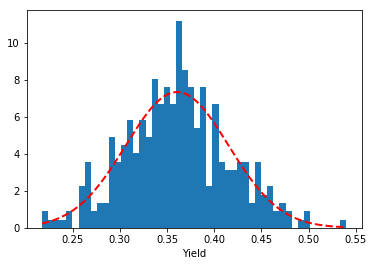

0.054436319309036856


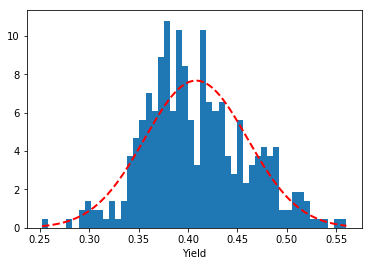

0.0520101769441758


IndexError: tuple index out of range

In [16]:


#Fano = find_fano(b, sigma)
#print(Fano)

i = 0
while i <=7:
    sigma = find_sigma(data[i])
    print(sigma)
    i += 1
    

In [ ]:
#for bin_data in data: 
 #   sigma = find_sigma(data) 
  #  print(sigma)

In [ ]:
mu1,sigma1 = norm.fit(Fano)
n,bins = np.histogram(Fano,600)
y = mlab.normpdf(bins, mu1, sigma1)

plt.figure()
plt.hist(Fano,normed = True)
plt.plot(bins,y,'r--',linewidth =2)
plt.xlabel("Fano Factor")
plt.show()
print("The extracted Fano Factor is:",mu1, "+-",sigma1)

print(np.average(Fano))
